# Investigating the Relationship Between EEG Features and Emotional States Induced by Video Stimuli Using the Arousal-Valence Model
Alading Kun

## import Packages

In [78]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample, hilbert, welch
import mne
from mne.preprocessing import ICA
from scipy.stats import skew, kurtosis

## Simulation for testing

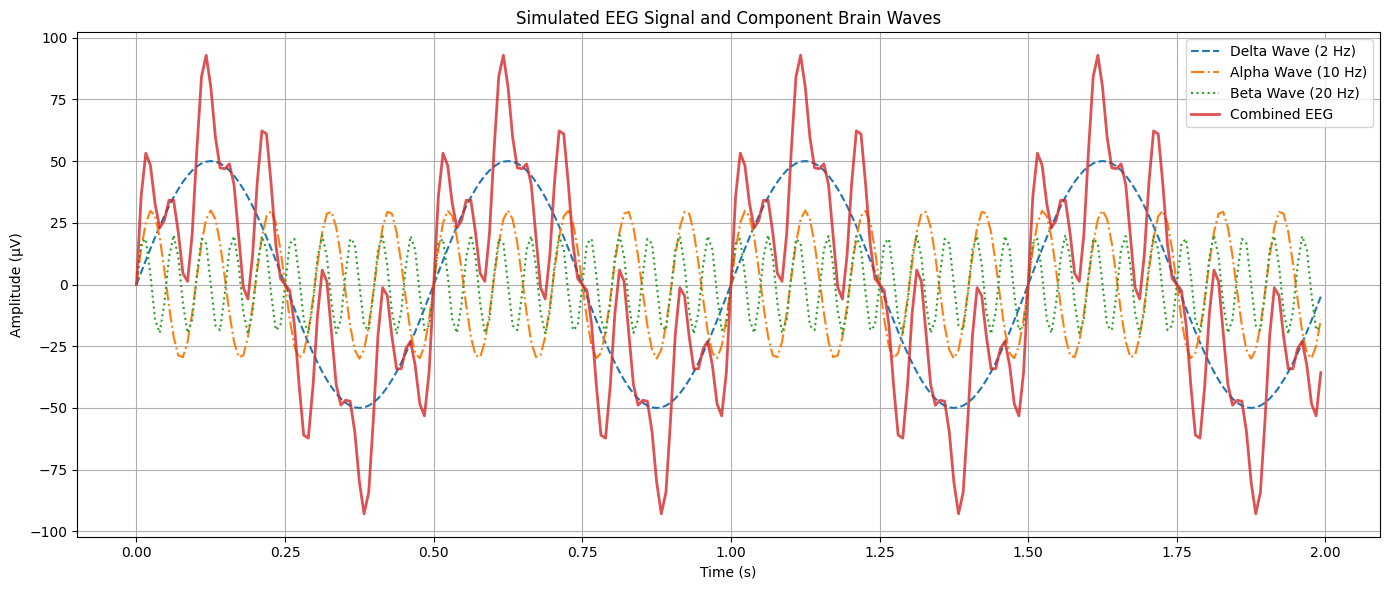

In [79]:
# Sampling setup
fs = 128  # Hz
t = np.linspace(0, 2, 2 * fs, endpoint=False)  # 2 seconds

# Create synthetic EEG components
delta_wave = 50 * np.sin(2 * np.pi * 2 * t)     # 2 Hz
alpha_wave = 30 * np.sin(2 * np.pi * 10 * t)    # 10 Hz
beta_wave  = 20 * np.sin(2 * np.pi * 20 * t)    # 20 Hz

# Combine to simulate EEG
eeg_wave = delta_wave + alpha_wave + beta_wave

# --- Plot ---
plt.figure(figsize=(14, 6))

plt.plot(t, delta_wave, label='Delta Wave (2 Hz)', linestyle='--')
plt.plot(t, alpha_wave, label='Alpha Wave (10 Hz)', linestyle='-.')
plt.plot(t, beta_wave,  label='Beta Wave (20 Hz)', linestyle=':')
plt.plot(t, eeg_wave,   label='Combined EEG', linewidth=2, alpha=0.8)

plt.title("Simulated EEG Signal and Component Brain Waves")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Read Data

In [80]:
# Paths
root_path = 'DEAP'
data_folder = os.path.join(root_path, 'data_preprocessed_python')

# Containers
all_subjects_data = []   # list of (trials, channels, samples)
all_subjects_labels = [] # list of (trials, 4)  [valence, arousal, dominance, liking]
subject_ids = []         # optional: list of subject IDs (e.g., 's01', 's02', ...)

# Loop through all .dat files sorted by subject number
for fname in sorted(os.listdir(data_folder)):
    if fname.endswith('.dat') and fname.startswith('s'):
        fpath = os.path.join(data_folder, fname)
        with open(fpath, 'rb') as f:
            data = pickle.load(f, encoding='latin1')
        eeg_data = data['data']    # shape (40, 40, 8064)
        labels = data['labels']    # shape (40, 4)
        
        all_subjects_data.append(eeg_data)
        all_subjects_labels.append(labels)
        subject_ids.append(fname[:-4])  # 's01' without '.dat'
        
        print(f"Loaded {fname}: EEG {eeg_data.shape}, labels {labels.shape}")

# Convert lists to numpy arrays if needed
# Shape would be (subjects, trials, channels, samples)
all_subjects_data = np.array(all_subjects_data, dtype=np.float32)
all_subjects_labels = np.array(all_subjects_labels, dtype=np.float32)

print("\nFinal shapes:")
print("EEG data:", all_subjects_data.shape)     # (n_subjects, 40, 40, 8064)
print("Labels:", all_subjects_labels.shape)     # (n_subjects, 40, 4)
print("Subjects:", subject_ids)

Loaded s01.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s02.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s03.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s04.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s05.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s06.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s07.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s08.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s09.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s10.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s11.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s12.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s13.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s14.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s15.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s16.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s17.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s18.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s19.dat: EEG (40, 40, 8064), labels (40, 4)
Loaded s20.dat: EEG (40, 40, 80

File Name data\SXX.dat, XX \in [0,31]

data: 40 x 40 x 8064: trial x channel x data

label: 40 x 4: video/trial x label (valence, arousal, dominance, liking)

Channel Indice: { 1 : AF3; 2: F3; 3: F7; 4: FC5; 7: T7; 11: P7; 13: O1
17: AF4; 19: F4; 20: F8; 21: FC6; 25: T8; 29: P8; 31: O2 }

In [81]:
all_subjects_data = all_subjects_data[:, :, :32, :]

In [82]:
all_subjects_data.shape

(32, 40, 32, 8064)

In [83]:
def bandpass_filter(data, lowcut, highcut, fs, order=4, axis=-1, verbose=True):
    """
    Apply a Butterworth bandpass filter.

    Parameters
    ----------
    data : np.ndarray
        EEG data array (time axis specified by `axis`).
    lowcut : float
        Lower cutoff frequency (Hz).
    highcut : float
        Upper cutoff frequency (Hz).
    fs : float
        Sampling frequency (Hz).
    order : int
        Filter order (default: 4).
    axis : int
        Axis representing time (default: last).
    verbose : bool
        If True, print filter details.

    Returns
    -------
    np.ndarray
        Filtered signal (same shape as input).
    """
    if highcut >= fs / 2:
        raise ValueError(f"Highcut frequency must be below Nyquist ({fs/2} Hz).")

    # Nyquist frequency
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    # Design Butterworth bandpass
    b, a = butter(order, [low, high], btype='band')

    if verbose:
        print(f"Applying Bandpass Filter: {lowcut}–{highcut} Hz, Order={order}, Fs={fs} Hz")
        print(f"Data shape: {data.shape} | Filtering along axis {axis}")

    # Apply zero-phase filtering
    filtered_data = filtfilt(b, a, data, axis=axis)

    if verbose:
        print("Filtering complete. Output shape:", filtered_data.shape)

    return filtered_data

In [84]:
# Parameters
fs = 128       # DEAP sampling rate
lowcut = 1.0   # lower bound
highcut = 45.0 # upper bound

filtered_data =  bandpass_filter(all_subjects_data, lowcut, highcut, fs)

Applying Bandpass Filter: 1.0–45.0 Hz, Order=4, Fs=128 Hz
Data shape: (32, 40, 32, 8064) | Filtering along axis -1
Filtering complete. Output shape: (32, 40, 32, 8064)


In [85]:
filtered_data.shape

(32, 40, 32, 8064)

Applying Bandpass Filter: 9–20 Hz, Order=4, Fs=128 Hz
Data shape: (256,) | Filtering along axis -1
Filtering complete. Output shape: (256,)


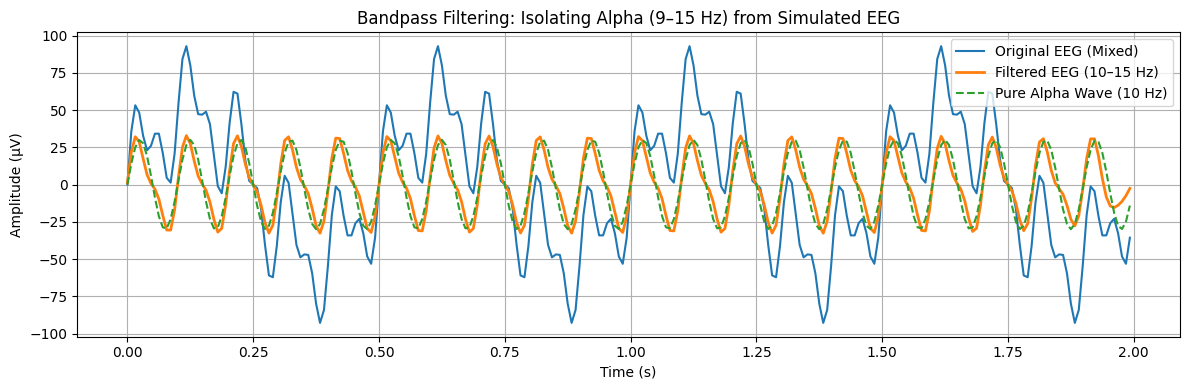

In [86]:
# Apply bandpass filter to isolate 10–15 Hz (alpha)
filtered_alpha = bandpass_filter(eeg_wave, 9, 20, fs)

# --- Plot ---
plt.figure(figsize=(12, 4))
plt.plot(t, eeg_wave, label='Original EEG (Mixed)')
plt.plot(t, filtered_alpha, label='Filtered EEG (10–15 Hz)', linewidth=2)
plt.plot(t, alpha_wave, label='Pure Alpha Wave (10 Hz)', linestyle='--')
plt.title("Bandpass Filtering: Isolating Alpha (9–15 Hz) from Simulated EEG")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Downsampling

In [87]:
def downsample_eeg(data, original_fs, target_fs, axis=-1, verbose=True):
    """
    Downsamples EEG data along the specified axis (time).

    Parameters
    ----------
    data : np.ndarray
        EEG array (..., samples) with time along `axis`.
    original_fs : float
        Original sampling rate (e.g., 128).
    target_fs : float
        Target sampling rate (must be less than original_fs).
    axis : int
        Axis representing time (default: -1).
    verbose : bool
        If True, print duration, resampling, and shape details.

    Returns
    -------
    np.ndarray
        Downsampled EEG data (same shape except time axis length changes).
    """
    if target_fs >= original_fs:
        raise ValueError("Target sampling rate must be less than original rate.")

    original_shape = data.shape
    total_samples = data.shape[axis]
    total_duration = total_samples / original_fs

    # Calculate new number of samples
    n_samples = int(round(total_samples * target_fs / original_fs))

    # Perform resampling along the chosen axis
    downsampled_data = resample(data, n_samples, axis=axis)

    if verbose:
        print(f"Original shape: {original_shape}")
        print(f"Original: {total_samples} samples @ {original_fs} Hz ({total_duration:.2f} s)")
        print(f"Downsampled shape: {downsampled_data.shape}")
        print(f"Downsampled: {n_samples} samples @ {target_fs} Hz ({total_duration:.2f} s)")
        print(f"Compression ratio: {total_samples/n_samples:.2f}x")

    return downsampled_data

In [88]:
fs = 128
target_fs = 64
downsampled_subject = downsample_eeg(all_subjects_data, fs, target_fs)

Original shape: (32, 40, 32, 8064)
Original: 8064 samples @ 128 Hz (63.00 s)
Downsampled shape: (32, 40, 32, 4032)
Downsampled: 4032 samples @ 64 Hz (63.00 s)
Compression ratio: 2.00x


Original shape: (256,)
Original: 256 samples @ 128 Hz (2.00 s)
Downsampled shape: (32,)
Downsampled: 32 samples @ 16 Hz (2.00 s)
Compression ratio: 8.00x


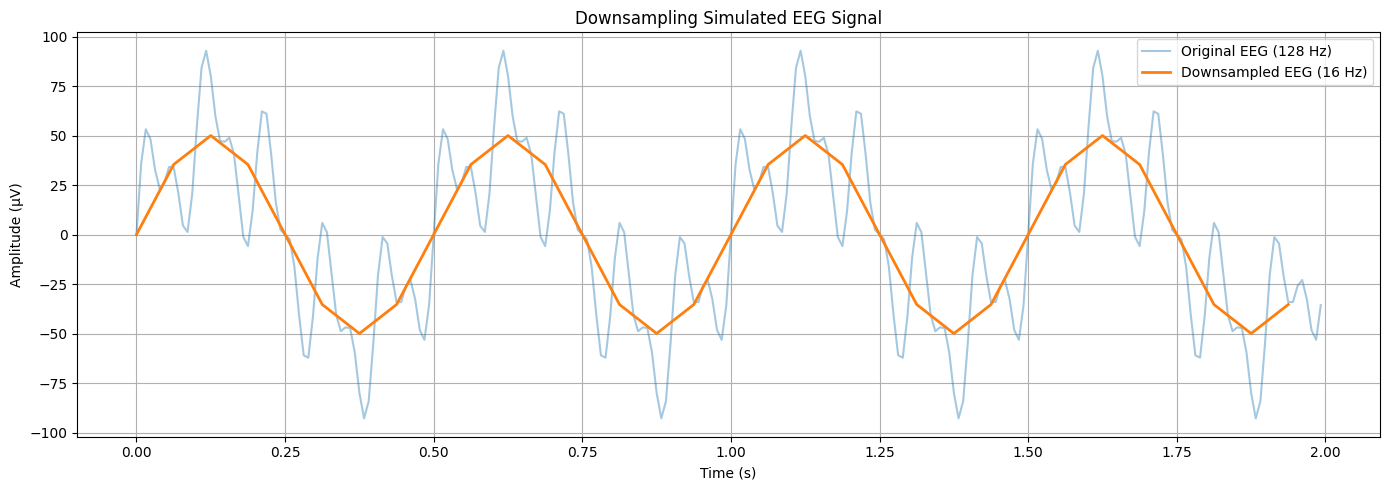

In [89]:
fs_target = 64  # Downsample from 128 Hz to 64 Hz
eeg_downsampled = downsample_eeg(eeg_wave, original_fs=128, target_fs=16)
t_downsampled = np.linspace(0, 2, len(eeg_downsampled), endpoint=False)

plt.figure(figsize=(14, 5))
plt.plot(t, eeg_wave, label='Original EEG (128 Hz)', alpha=0.4)
plt.plot(t_downsampled, eeg_downsampled, label='Downsampled EEG (16 Hz)', linewidth=2)
plt.title("Downsampling Simulated EEG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Baseline Removal

In [90]:
def select_time_segment(data, fs, start_sec, end_sec, axis=-1, verbose=True):
    """
    Select a segment of the signal based on start and end times.

    Parameters
    ----------
    data : np.ndarray
        EEG array with time on `axis` (e.g., trials×channels×samples or subjects×trials×channels×samples).
    fs : int or float
        Sampling rate in Hz.
    start_sec : float
        Start time in seconds (inclusive).
    end_sec : float
        End time in seconds (exclusive).
    axis : int
        Which axis is time (default: last).
    verbose : bool
        If True, print duration and shape details.

    Returns
    -------
    segment : np.ndarray
        Extracted segment of the same shape as input, except for the time axis length.
    """
    # Store original shape
    original_shape = data.shape

    # Get total duration
    total_samples = data.shape[axis]
    total_duration = total_samples / fs

    # Validate input times
    if start_sec < 0 or end_sec > total_duration:
        raise ValueError(f"Start ({start_sec}s) and End ({end_sec}s) must be within 0–{total_duration:.2f}s")
    if start_sec >= end_sec:
        raise ValueError("start_sec must be less than end_sec.")

    # Convert seconds to sample indices
    start_idx = int(round(start_sec * fs))
    end_idx = int(round(end_sec * fs))

    # Extract segment
    x = np.moveaxis(data, axis, -1)   # put time last
    segment = x[..., start_idx:end_idx]
    segment = np.moveaxis(segment, -1, axis)

    # Notification
    if verbose:
        seg_duration = (end_idx - start_idx) / fs
        print(f"Original shape: {original_shape}")
        print(f"Original duration: {total_duration:.2f} s ({total_samples} samples @ {fs} Hz)")
        print(f"Selected segment shape: {segment.shape}")
        print(f"Selected segment duration: {seg_duration:.2f} s ({end_idx - start_idx} samples)")
        print(f"From {start_sec:.2f} s to {end_sec:.2f} s")

    return segment

In [91]:
fs = 128
t = select_time_segment(filtered_data, fs, start_sec=3, end_sec=63)

Original shape: (32, 40, 32, 8064)
Original duration: 63.00 s (8064 samples @ 128 Hz)
Selected segment shape: (32, 40, 32, 7680)
Selected segment duration: 60.00 s (7680 samples)
From 3.00 s to 63.00 s


## Average re-referencing

In [92]:
def common_average_reference(
    data,
    channel_axis=1,          # axis for channels (DEAP: 1 for (trials, channels, samples))
    exclude=None,            # list/array of channel indices to EXCLUDE from the average
    verbose=True
):
    """
    Apply Common Average Referencing (CAR): subtract the mean across channels
    (computed at each time point) from every channel.

    Parameters
    ----------
    data : np.ndarray
        EEG array with a dedicated channels axis, e.g. (trials, channels, samples)
        or (subjects, trials, channels, samples).
    channel_axis : int
        Axis index that corresponds to channels.
    exclude : list[int] or np.ndarray or None
        Channel indices to exclude when computing the average reference
        (e.g., very noisy/bad channels). The reference is computed from the
        remaining channels and subtracted from ALL channels.
    verbose : bool
        If True, print shape and details.

    Returns
    -------
    car_data : np.ndarray
        CAR-referenced data with the same shape as input.
    """
    x = np.asarray(data, dtype=np.float64)
    orig_shape = x.shape

    n_ch = x.shape[channel_axis]
    if n_ch < 2:
        raise ValueError("CAR requires at least 2 channels.")

    # Build slicers for selecting good channels
    if exclude is None or len(exclude) == 0:
        # mean across all channels at each time sample
        ref = x.mean(axis=channel_axis, keepdims=True)
        used_ch = n_ch
    else:
        exclude = np.array(exclude, dtype=int)
        all_idx = np.arange(n_ch)
        good_idx = np.setdiff1d(all_idx, exclude)
        if good_idx.size == 0:
            raise ValueError("All channels were excluded; need at least one channel to compute reference.")
        # take only good channels for computing the average
        ref = np.take(x, good_idx, axis=channel_axis).mean(axis=channel_axis, keepdims=True)
        used_ch = good_idx.size

    car_data = x - ref  # broadcast subtraction across channels

    if verbose:
        print(f"CAR applied on data shape {orig_shape}")
        print(f"Channels axis: {channel_axis} | Total channels: {n_ch} | Used for ref: {used_ch}")
        if exclude is not None and len(exclude) > 0:
            print(f"Excluded channels from reference: {exclude.tolist()}")

    return car_data

In [ ]:
def extract_mean_feature(X):
    """Compute mean value of the signal over the last axis (time samples)."""
    return np.mean(X, axis=-1)

def extract_mean_absolute_value(X):
    """Compute mean absolute value (average magnitude of the signal)."""
    return np.mean(np.abs(X), axis=-1)

def extract_min_feature(X):
    """Find the minimum value of the signal."""
    return np.min(X, axis=-1)

def extract_max_feature(X):
    """Find the maximum value of the signal."""
    return np.max(X, axis=-1)

def extract_range_feature(X):
    """Compute the range (max - min) of the signal."""
    return np.max(X, axis=-1) - np.min(X, axis=-1)

def extract_std_feature(X):
    """Compute standard deviation of the signal (ddof=1 for sample std)."""
    return np.std(X, axis=-1, ddof=1)

def extract_variance_feature(X):
    """Compute variance of the signal (ddof=1 for sample variance)."""
    return np.var(X, axis=-1, ddof=1)

def extract_median_feature(X):
    """Find the median value of the signal."""
    return np.median(X, axis=-1)

# ===============================
# Signal difference features
# ===============================

def extract_mean_abs_first_diff(X):
    """Mean absolute value of the first-order difference (change between samples)."""
    diff = np.diff(X, axis=-1)                 # First differences
    abs_diff = np.abs(diff)                    # Absolute differences
    return np.mean(abs_diff, axis=-1)

def extract_mean_abs_second_diff(X):
    """Mean absolute value of the second-order difference (acceleration-like changes)."""
    second_diff = np.diff(X, n=2, axis=-1)      # Second differences
    abs_second_diff = np.abs(second_diff)
    return np.mean(abs_second_diff, axis=-1)

# ===============================
# Distribution shape features
# ===============================

def extract_skewness_feature(X):
    """Compute skewness (asymmetry of the amplitude distribution)."""
    return skew(X, axis=-1, bias=False)

def extract_kurtosis_feature(X):
    """Compute kurtosis (peakedness/flatness of the amplitude distribution).
       fisher=True means normal distribution has kurtosis of 0.
    """
    return kurtosis(X, axis=-1, fisher=True, bias=False)

# ===============================
# Crossing and amplitude features
# ===============================

def extract_zero_crossing_rate(X):
    """Proportion of times the signal changes sign (zero-crossing rate)."""
    signs = np.sign(X)
    crossings = (signs[..., :-1] * signs[..., 1:]) < 0
    return crossings.sum(axis=-1) / (X.shape[-1] - 1)

def extract_peak_amplitude(X):
    """Maximum absolute amplitude of the signal."""
    return np.max(np.abs(X), axis=-1)

# ===============================
# Energy and power features
# ===============================

def extract_signal_energy(X):
    """Total signal energy: sum of squared amplitudes."""
    return np.sum(X ** 2, axis=-1)

def extract_average_power(X):
    """Mean signal power: average of squared amplitudes."""
    return np.mean(X ** 2, axis=-1)

def extract_rms_feature(X):
    """Root mean square (RMS) amplitude."""
    return np.sqrt(np.mean(X ** 2, axis=-1))

# ===============================
# Temporal slope-based features
# ===============================

def extract_slope_sign_change(X):
    """Count slope sign changes — number of times slope direction changes."""
    diff1 = X[..., 1:-1] - X[..., :-2]  # slope before point
    diff2 = X[..., 1:-1] - X[..., 2:]   # slope after point
    return ((diff1 * diff2) > 0).sum(axis=-1)

def extract_willison_amplitude(X, threshold=0.01):
    """Count how many times the absolute diff between samples exceeds threshold."""
    diff = np.abs(np.diff(X, axis=-1))
    return (diff > threshold).sum(axis=-1)

# ===============================
# Wave count and duration
# ===============================

def extract_number_of_waves(X, fs=128, return_rate=False):
    """Estimate number of waves by counting zero-crossings."""
    signs = np.sign(X)
    zero_crossings = np.where(signs[..., :-1] * signs[..., 1:] < 0, 1, 0)
    n_crossings = zero_crossings.sum(axis=-1)
    n_waves = n_crossings // 2
    if return_rate:
        duration = X.shape[-1] / fs
        return n_waves / duration  # waves per second
    else:
        return n_waves

def extract_wave_duration(X, fs=128):
    """Estimate average wave duration (seconds per wave)."""
    n_waves = extract_number_of_waves(X, fs=fs, return_rate=False)
    duration = X.shape[-1] / fs
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(n_waves > 0, duration / n_waves, np.nan)

# ===============================
# Frequency-related features
# ===============================

def extract_mean_instantaneous_frequency(X, fs=128):
    """Compute mean instantaneous frequency using Hilbert transform."""
    analytic_signal = hilbert(X, axis=-1)
    inst_phase = np.unwrap(np.angle(analytic_signal), axis=-1)
    inst_freq = np.diff(inst_phase, axis=-1) * (fs / (2.0 * np.pi))
    return np.mean(inst_freq, axis=-1)

# ===============================
# Hjorth parameters
# ===============================

def extract_hjorth_parameters(X):
    """Compute Hjorth parameters: activity, mobility, complexity.
       - Activity: variance of signal
       - Mobility: sqrt(variance of diff / variance of signal)
       - Complexity: change in frequency content (ratio of mobilities)
    """
    dx = np.diff(X, axis=-1)
    ddx = np.diff(dx, axis=-1)

    var0 = np.var(X, axis=-1, ddof=1)    # activity
    var1 = np.var(dx, axis=-1, ddof=1)
    var2 = np.var(ddx, axis=-1, ddof=1)

    activity = var0
    mobility = np.sqrt(var1 / (var0 + 1e-12))
    complexity = np.sqrt((var2 / (var1 + 1e-12)) /
                         (var1 / (var0 + 1e-12) + 1e-12))

    return activity, mobility, complexity

# =====================================================
# Sample Entropy (SampEn)
# =====================================================

def compute_sample_entropy(X, m=2, r=0.2):
    """
    Compute Sample Entropy (SampEn) of EEG signals.
    
    Parameters:
        X : ndarray, shape (..., N)
            EEG time series (last axis = samples).
        m : int
            Embedding dimension (length of sequences to compare).
        r : float
            Tolerance (usually fraction of std, e.g., 0.2).
    
    Returns:
        sampen : ndarray, shape (...)
            Sample entropy value for each signal in X.
    
    Notes:
        - Low SampEn = signal is more regular/predictable.
        - High SampEn = signal is more irregular/complex.
    """
    # Ensure X is at least 2D for broadcasting
    X = np.atleast_2d(X)
    N = X.shape[-1]
    
    # Standard deviation for tolerance scaling
    std = np.std(X, axis=-1, ddof=0, keepdims=True)
    tol = r * std

    def _phi(m):
        # Build subsequences of length m
        shape = (X.shape[0], N - m + 1, m)
        subseq = np.lib.stride_tricks.sliding_window_view(X, m, axis=-1).reshape(shape)
        # Compute Chebyshev distance (max absolute difference)
        dist = np.max(np.abs(subseq[:, :, None, :] - subseq[:, None, :, :]), axis=-1)
        # Count matches (excluding self-matches)
        matches = np.sum(dist <= tol[..., None], axis=-1) - 1
        return np.sum(matches, axis=-1)

    B = _phi(m)      # matches for length m
    A = _phi(m + 1)  # matches for length m+1

    # Avoid division by zero
    sampen = -np.log((A + 1e-12) / (B + 1e-12))
    return sampen.squeeze()

# =====================================================
# PSD Computation
# =====================================================

def compute_welch_psd(eeg_data, fs=128, nperseg=None, noverlap=None, window='hann', scaling='density'):
    """
    Compute Power Spectral Density (PSD) for EEG data using Welch's method.
    
    Parameters:
        eeg_data : ndarray, shape (S, T, C, N)
            EEG data with shape (subjects, trials, channels, samples).
        fs : int or float
            Sampling rate in Hz.
        nperseg : int or None
            Length of each segment for Welch (in samples). Default = 2 * fs.
        noverlap : int or None
            Overlap between segments (in samples). Default = nperseg // 2.
        window : str
            Type of window to use (default: 'hann').
        scaling : str
            'density' (V^2/Hz) or 'spectrum' (V^2).

    Returns:
        freqs : ndarray, shape (F,)
            Array of frequency bins.
        psd : ndarray, shape (S, T, C, F)
            Power Spectral Density values for each subject, trial, and channel.
    """
    S, T, C, N = eeg_data.shape
    if nperseg is None:
        nperseg = int(2 * fs)
    if noverlap is None:
        noverlap = nperseg // 2

    psd_list = []
    freqs = None

    for subj in range(S):
        trial_list = []
        for trial in range(T):
            ch_list = []
            for ch in range(C):
                f, Pxx = welch(eeg_data[subj, trial, ch], fs=fs,
                               nperseg=nperseg, noverlap=noverlap,
                               window=window, scaling=scaling)
                if freqs is None:
                    freqs = f
                ch_list.append(Pxx)
            trial_list.append(np.array(ch_list))
        psd_list.append(np.array(trial_list))

    psd_array = np.array(psd_list)
    return freqs, psd_array


# =====================================================
# Absolute & Relative Band Powers
# =====================================================

def extract_absolute_band_powers(freqs, psd):
    """
    Compute absolute band powers by integrating PSD over frequency bands.

    Parameters:
        freqs : ndarray, shape (F,)
            Frequency bins from Welch's method.
        psd : ndarray, shape (S, T, C, F)
            Power Spectral Density values.

    Returns:
        band_powers : ndarray, shape (S, T, C, B)
            Absolute power in each band.
        band_names : list
            Names of the bands in order.
    """
    bands = {
        "delta": (0.5, 4),
        "theta": (4, 8),
        "alpha": (8, 12),
        "sigma": (12, 14),  # sleep spindle band
        "beta":  (12, 30),
        "gamma": (30, 45)
    }

    S, T, C, F = psd.shape
    B = len(bands)
    band_powers = np.zeros((S, T, C, B))
    band_names = list(bands.keys())

    for idx, (band, (low, high)) in enumerate(bands.items()):
        mask = (freqs >= low) & (freqs <= high)
        band_powers[..., idx] = np.trapezoid(psd[..., mask], freqs[mask], axis=-1)

    return band_powers, band_names


def extract_relative_band_powers(freqs, psd):
    """
    Compute relative band powers by normalizing absolute powers with total power.

    Parameters:
        freqs : ndarray, shape (F,)
            Frequency bins from Welch's method.
        psd : ndarray, shape (S, T, C, F)
            Power Spectral Density values.

    Returns:
        rel_band_powers : ndarray, shape (S, T, C, B)
            Relative power in each band (fraction of total power).
        band_names : list
            Names of the bands in order.
    """
    bands = {
        "delta": (0.5, 4),
        "theta": (4, 8),
        "alpha": (8, 12),
        "sigma": (12, 14),
        "beta":  (12, 30),
        "gamma": (30, 45)
    }

    S, T, C, F = psd.shape
    B = len(bands)
    rel_band_powers = np.zeros((S, T, C, B))

    total_power = np.trapezoid(psd, freqs, axis=-1)
    total_power = total_power[..., np.newaxis]

    band_names = list(bands.keys())
    for idx, (band, (low, high)) in enumerate(bands.items()):
        mask = (freqs >= low) & (freqs <= high)
        band_power = np.trapezoid(psd[..., mask], freqs[mask], axis=-1)
        rel_band_powers[..., idx] = band_power / (total_power[..., 0] + 1e-12)

    return rel_band_powers, band_names


# =====================================================
# Band Ratios
# =====================================================

def compute_band_ratios(band_powers, band_names):
    """
    Compute EEG band power ratios (e.g., theta/alpha, beta/alpha, etc.).

    Parameters:
        band_powers : ndarray, shape (S, T, C, B)
            Absolute or relative band power values.
        band_names : list
            Names of the bands corresponding to band_powers.

    Returns:
        ratios : dict
            Dictionary where keys = ratio names, values = ndarray (S, T, C).
    """
    idx = {name: i for i, name in enumerate(band_names)}
    ratios = {}

    if "theta" in idx and "alpha" in idx:
        ratios["theta_alpha"] = band_powers[..., idx["theta"]] / (band_powers[..., idx["alpha"]] + 1e-12)

    if "beta" in idx and "alpha" in idx:
        ratios["beta_alpha"] = band_powers[..., idx["beta"]] / (band_powers[..., idx["alpha"]] + 1e-12)

    if "theta" in idx and "beta" in idx:
        ratios["theta_beta"] = band_powers[..., idx["theta"]] / (band_powers[..., idx["beta"]] + 1e-12)

    if all(b in idx for b in ["theta", "alpha", "beta"]):
        ratios["(theta+alpha)_beta"] = (band_powers[..., idx["theta"]] + band_powers[..., idx["alpha"]]) / \
                                      (band_powers[..., idx["beta"]] + 1e-12)

    if "delta" in idx and "alpha" in idx:
        ratios["delta_alpha"] = band_powers[..., idx["delta"]] / (band_powers[..., idx["alpha"]] + 1e-12)

    if "delta" in idx and "theta" in idx:
        ratios["delta_theta"] = band_powers[..., idx["delta"]] / (band_powers[..., idx["theta"]] + 1e-12)

    if all(b in idx for b in ["delta", "theta", "alpha", "beta"]):
        ratios["(delta+theta)_(alpha+beta)"] = \
            (band_powers[..., idx["delta"]] + band_powers[..., idx["theta"]]) / \
            (band_powers[..., idx["alpha"]] + band_powers[..., idx["beta"]] + 1e-12)

    if all(b in idx for b in ["theta", "alpha", "beta"]):
        ratios["(theta+alpha)_(alpha+beta)"] = \
            (band_powers[..., idx["theta"]] + band_powers[..., idx["alpha"]]) / \
            (band_powers[..., idx["alpha"]] + band_powers[..., idx["beta"]] + 1e-12)

    if "gamma" in idx and "delta" in idx:
        ratios["gamma_delta"] = band_powers[..., idx["gamma"]] / (band_powers[..., idx["delta"]] + 1e-12)

    if all(b in idx for b in ["gamma", "beta", "delta", "alpha"]):
        ratios["(gamma+beta)_(delta+alpha)"] = \
            (band_powers[..., idx["gamma"]] + band_powers[..., idx["beta"]]) / \
            (band_powers[..., idx["delta"]] + band_powers[..., idx["alpha"]] + 1e-12)

    return ratios


# =====================================================
# Peak Frequency
# =====================================================

def compute_peak_frequencies(freqs, psd, bands=None):
    """
    Compute peak frequency within each band for EEG PSD data.
    
    Parameters:
        freqs : ndarray, shape (F,)
            Frequency bins from Welch's method.
        psd : ndarray, shape (S, T, C, F)
            Power Spectral Density values.
        bands : dict or None
            Dict of frequency bands, e.g., {"alpha": (8, 13)}.
            If None, defaults to standard EEG bands.

    Returns:
        peak_freqs : ndarray, shape (S, T, C, B)
            Peak frequency in each band for each subject, trial, and channel.
        band_names : list
            Names of the bands.
    """
    if bands is None:
        bands = {
            "delta": (0.5, 4),
            "theta": (4, 8),
            "alpha": (8, 12),
            "sigma": (12, 14),
            "beta":  (12, 30),
            "gamma": (30, 45)
        }

    S, T, C, F = psd.shape
    B = len(bands)
    peak_freqs = np.zeros((S, T, C, B))
    band_names = list(bands.keys())

    for idx, (band, (low, high)) in enumerate(bands.items()):
        mask = (freqs >= low) & (freqs <= high)
        band_psd = psd[..., mask]
        band_freqs = freqs[mask]

        peak_idx = np.argmax(band_psd, axis=-1)
        peak_freqs[..., idx] = band_freqs[peak_idx]

    return peak_freqs, band_names


# =====================================================
# PSD Statistical Features
# =====================================================

def compute_psd_statistics(psd):
    """
    Compute statistical descriptors of PSD distribution across frequencies.
    
    Parameters:
        psd : ndarray, shape (S, T, C, F)
            Power Spectral Density values.
    
    Returns:
        stats : dict of ndarrays
            Dictionary with keys:
                'psd_mean'      : mean of PSD, shape (S, T, C)
                'psd_median'    : median of PSD, shape (S, T, C)
                'psd_variance'  : variance of PSD, shape (S, T, C)
                'psd_std'       : standard deviation of PSD, shape (S, T, C)
                'psd_skewness'  : skewness of PSD, shape (S, T, C)
                'psd_kurtosis'  : kurtosis of PSD, shape (S, T, C)
    """
    stats = {
        "psd_mean": np.mean(psd, axis=-1),
        "psd_median": np.median(psd, axis=-1),
        "psd_variance": np.var(psd, axis=-1, ddof=1),
        "psd_std": np.std(psd, axis=-1, ddof=1),
        "psd_skewness": skew(psd, axis=-1, bias=False),
        "psd_kurtosis": kurtosis(psd, axis=-1, fisher=True, bias=False)
    }
    return stats

# =====================================================
# Spectral Entropy
# =====================================================

def compute_spectral_entropy(freqs, psd):
    """
    Compute spectral entropy of EEG PSD.
    
    Parameters:
        freqs : ndarray, shape (F,)
            Frequency bins from Welch's method.
        psd : ndarray, shape (S, T, C, F)
            Power Spectral Density values.
    
    Returns:
        entropy : ndarray, shape (S, T, C)
            Shannon entropy of normalized PSD for each subject, trial, and channel.
    """
    # Normalize PSD to a probability distribution
    psd_norm = psd / (np.sum(psd, axis=-1, keepdims=True) + 1e-12)
    entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-12), axis=-1)
    return entropy


# =====================================================
# Spectral Edge Frequency (SEF95)
# =====================================================

def compute_spectral_edge_frequency(freqs, psd, edge=0.95):
    """
    Compute spectral edge frequency (e.g., SEF95).
    
    Parameters:
        freqs : ndarray, shape (F,)
            Frequency bins from Welch's method.
        psd : ndarray, shape (S, T, C, F)
            Power Spectral Density values.
        edge : float
            Proportion of total power (default = 0.95).
    
    Returns:
        sef : ndarray, shape (S, T, C)
            Spectral edge frequency values for each subject, trial, and channel.
    """
    # Compute cumulative sum of power spectrum
    cumsum_power = np.cumsum(psd, axis=-1)
    total_power = cumsum_power[..., -1][..., np.newaxis]

    # Normalize to [0, 1]
    cumsum_norm = cumsum_power / (total_power + 1e-12)

    # Find frequency index where cumulative power crosses "edge" (e.g., 95%)
    idx_edge = np.argmax(cumsum_norm >= edge, axis=-1)

    # Map to actual frequency
    sef = freqs[idx_edge]
    return sef


# =====================================================
# Spectral Centroid (Center of Gravity)
# =====================================================

def compute_spectral_centroid(freqs, psd):
    """
    Compute spectral centroid (frequency center of gravity).
    
    Parameters:
        freqs : ndarray, shape (F,)
            Frequency bins from Welch's method.
        psd : ndarray, shape (S, T, C, F)
            Power Spectral Density values.
    
    Returns:
        centroid : ndarray, shape (S, T, C)
            Spectral centroid frequency for each subject, trial, and channel.
    """
    weighted_sum = np.sum(freqs * psd, axis=-1)
    total_power = np.sum(psd, axis=-1)
    centroid = weighted_sum / (total_power + 1e-12)
    return centroid

# =====================================================
# Permutation Entropy
# =====================================================

def compute_permutation_entropy(X, m=3, tau=1):
    """
    Compute Permutation Entropy (PE) of EEG signals.

    Parameters:
        X : ndarray, shape (..., N)
            EEG time series (last axis = samples).
        m : int
            Embedding dimension (pattern length).
        tau : int
            Time delay for embedding.

    Returns:
        pe : ndarray, shape (...)
            Permutation entropy value for each signal in X.

    Notes:
        - Low PE = signal is more regular.
        - High PE = signal is more complex/unpredictable.
    """
    X = np.atleast_2d(X)
    N = X.shape[-1]
    pe = np.zeros(X.shape[:-1])

    for idx in np.ndindex(X.shape[:-1]):
        ts = X[idx]
        n_patterns = N - (m - 1) * tau
        if n_patterns <= 0:
            pe[idx] = np.nan
            continue

        # Build ordinal patterns
        patterns = np.zeros((n_patterns, m))
        for j in range(m):
            patterns[:, j] = ts[j*tau : j*tau+n_patterns]

        # Get ranks for each pattern
        ranks = np.argsort(np.argsort(patterns, axis=1), axis=1)

        # Count frequency of each ordinal pattern
        _, counts = np.unique(ranks, axis=0, return_counts=True)
        probs = counts / counts.sum()

        # Shannon entropy
        pe[idx] = -np.sum(probs * np.log2(probs + 1e-12))

    return pe.squeeze()


# =====================================================
# Fractal Dimension (Higuchi's Method)
# =====================================================

def compute_higuchi_fd(X, kmax=10):
    """
    Compute Higuchi Fractal Dimension (FD) of EEG signals.

    Parameters:
        X : ndarray, shape (..., N)
            EEG time series (last axis = samples).
        kmax : int
            Maximum interval for computing curve length.

    Returns:
        fd : ndarray, shape (...)
            Higuchi fractal dimension value for each signal in X.

    Notes:
        - Higher FD = more complex signal.
        - Lower FD = smoother/more regular signal.
    """
    X = np.atleast_2d(X)
    N = X.shape[-1]
    fd = np.zeros(X.shape[:-1])

    for idx in np.ndindex(X.shape[:-1]):
        ts = X[idx]
        L = []
        k_vals = np.arange(1, kmax+1)

        for k in k_vals:
            Lk = []
            for m in range(k):
                idxs = np.arange(m, N, k)
                if len(idxs) < 2:
                    continue
                diffs = np.abs(np.diff(ts[idxs]))
                Lm = np.sum(diffs) * (N-1) / (len(idxs)*k)
                Lk.append(Lm)
            L.append(np.mean(Lk) if Lk else 0)

        # Linear fit in log-log space
        L = np.array(L)[L > 0]
        k_vals = k_vals[:len(L)]
        coeffs = np.polyfit(np.log(k_vals), np.log(L), 1)
        fd[idx] = -coeffs[0]

    return fd.squeeze()


# =====================================================
# Spectral Slope (1/f Exponent)
# =====================================================

def compute_spectral_slope(freqs, psd, fmin=1, fmax=45):
    """
    Compute spectral slope (1/f exponent) of EEG PSD.

    Parameters:
        freqs : ndarray, shape (F,)
            Frequency bins from Welch's method.
        psd : ndarray, shape (S, T, C, F)
            Power Spectral Density values.
        fmin : float
            Minimum frequency for fitting.
        fmax : float
            Maximum frequency for fitting.

    Returns:
        slope : ndarray, shape (S, T, C)
            Spectral slope (1/f exponent).
        intercept : ndarray, shape (S, T, C)
            Intercept of log-log fit.

    Notes:
        - Steeper slope (more negative) = stronger low-frequency dominance.
        - Flatter slope (closer to 0) = more high-frequency content.
    """
    mask = (freqs >= fmin) & (freqs <= fmax)
    freqs_masked = freqs[mask]
    log_freqs = np.log10(freqs_masked)

    log_psd = np.log10(psd[..., mask] + 1e-12)  # shape (S, T, C, F_mask)

    # Fit linear regression for each (S,T,C)
    S, T, C, F = log_psd.shape
    slope = np.zeros((S, T, C))
    intercept = np.zeros((S, T, C))

    for s in range(S):
        for t in range(T):
            for c in range(C):
                y = log_psd[s, t, c]
                coeffs = np.polyfit(log_freqs, y, 1)
                slope[s, t, c], intercept[s, t, c] = coeffs

    return slope, intercept

In [41]:
def compile_features_dataframe(
    X, fs=128, channel_names=None, willison_thresh=0.01
):
    """
    X: ndarray (subjects, trials, channels, samples)
    Returns: DataFrame with one row per (subject, trial, channel),
             and one column per feature.
    """
    if not isinstance(X, np.ndarray) or X.ndim != 4:
        raise ValueError("Expected X as numpy array with shape (subjects, trials, channels, samples).")
    S, T, C, N = X.shape

    feats = {}
    feats["mean"]                  = extract_mean_feature(X)
    feats["mav"]                   = extract_mean_absolute_value(X)
    feats["min"]                   = extract_min_feature(X)
    feats["max"]                   = extract_max_feature(X)
    feats["range"]                 = extract_range_feature(X)
    feats["std"]                   = extract_std_feature(X)
    feats["var"]                   = extract_variance_feature(X)
    feats["median"]                = extract_median_feature(X)
    feats["mean_abs_diff1"]        = extract_mean_abs_first_diff(X)
    feats["mean_abs_diff2"]        = extract_mean_abs_second_diff(X)
    feats["skew"]                  = extract_skewness_feature(X)
    feats["kurtosis"]              = extract_kurtosis_feature(X)
    feats["zcr"]                   = extract_zero_crossing_rate(X)
    feats["peak_amp"]              = extract_peak_amplitude(X)
    feats["energy"]                = extract_signal_energy(X)
    feats["avg_power"]             = extract_average_power(X)
    feats["rms"]                   = extract_rms_feature(X)
    feats["ssc"]                   = extract_slope_sign_change(X)
    feats["willison_amp"]          = extract_willison_amplitude(X, threshold=willison_thresh)
    feats["n_waves"]               = extract_number_of_waves(X, fs=fs, return_rate=False)
    feats["wave_duration_s"]       = extract_wave_duration(X, fs=fs)
    feats["mean_inst_freq_hz"]     = extract_mean_instantaneous_frequency(X, fs=fs)
    hj_a, hj_m, hj_c               = extract_hjorth_parameters(X)
    feats["hjorth_activity"]       = hj_a
    feats["hjorth_mobility"]       = hj_m
    feats["hjorth_complexity"]     = hj_c

    # Build index columns
    nrows = S * T * C
    subjects = np.repeat(np.arange(S), T * C)
    trials   = np.tile(np.repeat(np.arange(T), C), S)
    channels = np.tile(np.arange(C), S * T)
    if channel_names is not None:
        channels_out = np.asarray(channel_names)[channels]
    else:
        channels_out = channels

    data = {"subject": subjects, "trial": trials, "channel": channels_out}
    for name, arr in feats.items():
        data[name] = arr.reshape(-1)  # flatten (S,T,C) -> (S*T*C,)

    return pd.DataFrame(data)

# ---------- Use it with your data ----------
# all_subjects_data: expected shape (S, T, C, N)
# Set your sampling rate here:
fs = 128  # <-- change if different
# Optional channel names list of length C:
channel_names = None  # e.g., ["Fp1","Fp2","F3",...]

df_features = compile_features_dataframe(all_subjects_data, fs=fs, channel_names=channel_names)